In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests
import multiprocessing
import time

In [2]:
# Floyd-Warshall algorithm
def floyd_warshall(AdjMatrix):
    n = len(AdjMatrix)
    cost = np.copy(AdjMatrix)
    cost[cost == 0] = np.inf
    for k in range(n):
        for i in range(n):
            for j in range(n):
                cost[i, j] = min(cost[i, j], cost[i, k] + cost[k, j])
    return cost

In [4]:
def shortest_path_kernel1(S1, S2, k_walk):
    # Obtener índices donde las entradas son finitas
    indices_S1 = np.transpose(np.triu_indices_from(S1))
    indices_S2 = np.transpose(np.triu_indices_from(S2))
    
    # Filtrar valores finitos
    indices_S1 = indices_S1[np.isfinite(S1[indices_S1[:, 0], indices_S1[:, 1]])]
    indices_S2 = indices_S2[np.isfinite(S2[indices_S2[:, 0], indices_S2[:, 1]])]

    # Convertir las entradas relevantes en arrays
    S1_finite = S1[indices_S1[:, 0], indices_S1[:, 1]]
    S2_finite = S2[indices_S2[:, 0], indices_S2[:, 1]]

    # Calcular el kernel con producto cartesiano sin crear listas grandes
    K = 0
    for d1 in S1_finite:
        for d2 in S2_finite:
            K += k_walk(d1, d2)

    return K

def shortest_path_kernel2(S1, S2, k_walk):
    K = 0
    n = len(S1)
    m = len(S2)
    for i in range(n):
        for j in range(i, n):
            for ii in range(m):
                for jj in range(ii, m):
                    if np.isfinite(S1[i, j]) and np.isfinite(S2[ii, jj]):
                        K += k_walk(S1[i, j], S2[ii, jj])
    return K

def shortest_path_kernel(S1, S2, k_walk):
    try:
        return shortest_path_kernel1(S1, S2, k_walk)
    except Exception as e:
        print(f"Error: {e}, trying another approach")
        return shortest_path_kernel2(S1, S2, k_walk)

In [5]:
# kernel walk functions
def dirac_kernel(a, b):
    return 1 if a == b else 0
    
def gaussian_kernel(a,b, sigma = 1/10):
    return np.exp(-((a-b)**2)*sigma)

def inverse_multiquadratic_kernel(a,b):
    return 1/np.sqrt(1+(a-b)**2)

In [6]:
# function to compute the gram matrix

def gram_matrix(data, k_function, normalized=False, save=False, directory=None):
    """This function computes the Gram matrix of the data using the kernel function k_function.
    
    Parameters:
    data: list of matrices
    k_function: kernel function which takes two matrices as input
    normalized: boolean, if True the Gram matrix is normalized
    save: boolean, if True the Gram matrix is saved in the specified directory
    directory: string, directory where the Gram matrix is saved
    
    Returns:
    gram: Gram matrix of the data
    """
    n = len(data)
    gram = np.zeros((n, n))

    # Compute only the upper triangle of the Gram matrix
    for i in range(n):
        for j in range(i, n):
            gram[i, j] = k_function(data[i], data[j])
            if i != j:
                gram[j, i] = gram[i, j]

    # Normalize the Gram matrix if required
    if normalized:
        diag = np.sqrt(np.diag(gram))
        gram = gram / np.outer(diag, diag)

    # Save the Gram matrix to a file if required
    if save:
        if directory is None:
            raise ValueError("Directory must be specified if save is True.")
        os.makedirs(directory, exist_ok=True)
        np.save(os.path.join(directory, 'gram_matrix.npy'), gram)

    return gram

In [45]:
def count_trips_ecobici(data_user, threshold = 5, complement = False):
    viajes_user = data_user.groupby([data_user[['Ciclo_Estacion_Retiro', 'Ciclo_Estacion_Arribo']].min(axis=1), data_user[['Ciclo_Estacion_Retiro', 'Ciclo_Estacion_Arribo']].max(axis=1)]).size().reset_index(name='counts')
    viajes_user.columns = ['Est_A', 'Est_B', 'counts']
    if not complement:
        viajes_user = viajes_user[viajes_user['counts'] >= threshold]
    else:
        viajes_user = viajes_user[viajes_user['counts'] < threshold]
    if viajes_user.empty:
        return None
    total = viajes_user['counts'].sum()
    viajes_user['prob'] = viajes_user['counts']/total
    viajes_user = viajes_user.sort_values(by = 'prob', ascending = False).reset_index(drop=True)
    return viajes_user

def compute_matrix(counter_user, normalized = False, self_loops = False):
    if not self_loops:
        counter_user = counter_user[counter_user['Est_A'] != counter_user['Est_B']]
    vertex = list(set(counter_user['Est_A'].unique().tolist() + counter_user['Est_B'].unique().tolist()))
    matrix = np.zeros((len(vertex), len(vertex)))
    for i in range(len(counter_user)):
        current_trip = counter_user.iloc[i]
        count = current_trip["counts"]
        estA = current_trip["Est_A"]
        estB = current_trip["Est_B"]

        matrix[vertex.index(estA)][vertex.index(estB)] = count
        matrix[vertex.index(estB)][vertex.index(estA)] = count
    if normalized:
        D = np.sum(matrix, axis = 1)
        D = np.diag(D)
        D = np.linalg.inv(np.sqrt(D))
        matrix = D @ matrix @ D
    return matrix

In [7]:
#dir = '/home/user/Desktop/Datos/'
dir = '/Users/antoniomendez/Desktop/Tesis/Datos/datos_limpios/'

Ahora, con datos de la ciudad de méxico

# Limpieza

In [36]:
# correccion de datos

years = ['2019', '2020', '2021', '2022', '2023', '2024']

for year in years:
    print("Procesando año", year)
    # Cargar datos
    data = pd.read_csv(dir + f'ecobici/{year}.csv')
    
    # Convertir los valores en 'Bici' a numéricos, convirtiendo los errores a NaN
    data['Bici'] = pd.to_numeric(data['Bici'], errors='coerce')
    
    # Eliminar filas con NaN en la columna 'Bici'
    data.dropna(subset=['Bici'], inplace=True)
    
    # Convertir la columna 'Bici' a tipo int64
    data['Bici'] = data['Bici'].astype('int64')
    
    # Guardar los datos corregidos en el archivo CSV
    data.to_csv(dir + f'ecobici/{year}.csv', index=False)


Procesando año 2019


/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/3335259633.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dir + f'ecobici/{year}.csv')


Procesando año 2020


/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/3335259633.py:8: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dir + f'ecobici/{year}.csv')


Procesando año 2021
Procesando año 2022


/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/3335259633.py:8: DtypeWarning: Columns (0,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dir + f'ecobici/{year}.csv')


Procesando año 2023
Procesando año 2024


In [46]:
data_2019 = pd.read_csv(dir + 'ecobici/2019.csv')

In [47]:
print(data_2019.dtypes)

Genero_Usuario            object
Edad_Usuario               int64
Bici                       int64
Ciclo_Estacion_Retiro      int64
Fecha_Retiro              object
Hora_Retiro               object
Ciclo_Estacion_Arribo      int64
Fecha_Arribo              object
Hora_Arribo               object
Tiempo_viaje             float64
dtype: object


In [49]:
print(data_2019['Genero_Usuario'].unique())
print(data_2019['Edad_Usuario'].unique())
print(data_2019['Ciclo_Estacion_Retiro'].unique())
print(data_2019['Ciclo_Estacion_Arribo'].unique())
print(data_2019['Fecha_Retiro'].unique())
print(data_2019['Hora_Retiro'].unique())
print(data_2019['Fecha_Arribo'].unique())
print(data_2019['Hora_Arribo'].unique())
print(data_2019['Tiempo_viaje'].unique())

['M' 'F']
[ 36  38  43  37  44  23  31  27  21  46  29  34  39  47  19  35  28  68
  30  33  55  50  25  26  24  51  42  32  71  40  41  48  54  65  53  22
  52  57  61  70  63  60  76  49  58  45  67  18  59  56  20  66  72  73
  69  64  62  77  17  78  75  16  74  82  83  79  84  81  92  80 108  96
 119 118  97  85 101  98]
[ 67  55  29 136   2  49  80  69  10 115  82  47  43  34 161 185 169  35
  23  97 125 186   6 342 146 353  30 298 347  64 107 417  68  36 182 188
 421 295 191 171 189 166  70 281 151 306 414 458 340   3 216 140 187 117
 133 183 337  15 230 135  41 284 179 297 165  86 208 246 472  22 356 300
  73 308 194 390 440 153  54   5  46 139 271  21 178 108 474   1 385 310
 124 175 164 270 396  48 192 174 450 359 119  28 406   9 286 439 291  59
 352 285 309  13 219 277 371  93 167 404 248  26 328 180 232 158  44  57
 382  62 292 112 195 413  38 197 480 358 452 394   4  85  84 278 256  74
 276 134 111 409 386 377 204 260 128 130 147 163 168 448 321  77  66 476
 103  99  89 11

In [50]:
# Contar filas con NaNs
nans_count = data_2019.isna().sum().sum()
print(f'Número de NaNs en el dataset: {nans_count}')

Número de NaNs en el dataset: 0


In [51]:
# Cambiar el formato de las fechas en el dataframe data_2019
data_2019['Fecha_Retiro'] = pd.to_datetime(data_2019['Fecha_Retiro'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
data_2019['Fecha_Arribo'] = pd.to_datetime(data_2019['Fecha_Arribo'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [52]:
data_2019.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Tiempo_viaje
0,M,36,11444,67,2019-01-01,0:08:44,36,2019-01-01,0:14:03,5.316667
1,M,36,9196,55,2019-01-01,0:12:05,136,2019-01-01,0:42:11,30.100000
2,M,38,2612,29,2019-01-01,0:13:15,115,2019-01-01,0:37:47,24.533333
3,M,43,7463,29,2019-01-01,0:13:36,115,2019-01-01,0:38:04,24.466667
4,M,37,3987,136,2019-01-01,0:15:30,35,2019-01-01,0:22:47,7.283333


In [53]:
data_2019.to_csv(dir + 'ecobici/2019.csv', index=False)

In [54]:
len(data_2019)

8382178

In [55]:
data_2020 = pd.read_csv(dir + 'ecobici/2020.csv')

In [56]:
data_2020.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,BikeID,Tiempo_viaje
0,F,33.0,8744,52.0,01/01/2020,0:05:06,3,01/01/2020,0:13:00,NaN,7.900000
1,M,30.0,7865,31.0,01/01/2020,0:09:50,271,01/01/2020,0:21:30,NaN,11.666667
2,F,36.0,7819,251.0,01/01/2020,0:13:25,150,01/01/2020,0:26:10,NaN,12.750000
3,F,33.0,11258,3.0,01/01/2020,0:15:22,1,01/01/2020,0:25:29,NaN,10.116667
4,M,29.0,7722,136.0,01/01/2020,0:18:42,63,01/01/2020,0:24:01,NaN,5.316667


In [57]:
data_2020 = data_2020.drop(columns=['BikeID'])

In [58]:
data_2020.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Tiempo_viaje
0,F,33.0,8744,52.0,01/01/2020,0:05:06,3,01/01/2020,0:13:00,7.900000
1,M,30.0,7865,31.0,01/01/2020,0:09:50,271,01/01/2020,0:21:30,11.666667
2,F,36.0,7819,251.0,01/01/2020,0:13:25,150,01/01/2020,0:26:10,12.750000
3,F,33.0,11258,3.0,01/01/2020,0:15:22,1,01/01/2020,0:25:29,10.116667
4,M,29.0,7722,136.0,01/01/2020,0:18:42,63,01/01/2020,0:24:01,5.316667


In [59]:
print(data_2020['Genero_Usuario'].unique())
print(data_2020['Edad_Usuario'].unique())
print(data_2020['Ciclo_Estacion_Retiro'].unique())
print(data_2020['Ciclo_Estacion_Arribo'].unique())
print(data_2020['Fecha_Retiro'].unique())
print(data_2020['Hora_Retiro'].unique())
print(data_2020['Fecha_Arribo'].unique())
print(data_2020['Hora_Arribo'].unique())
print(data_2020['Tiempo_viaje'].unique())

['F' 'M' nan]
[ 33.  30.  36.  29.  49.  17.  35.  25.  32.  37.  28.  55.  58.  31.
  62.  60.  44.  42.  51.  34.  24.  22.  48.  41.  39.  40.  26.  46.
  56.  43.  38.  47.  21.  27.  50.  57.  64.  20.  69.  72.  23.  18.
  66.  52.  61.  63.  45.  54.  71.  53.  65.  77.  68.  59.  75.  67.
  19.  74.  73.  70.  78.  16.  76.  79.  94.  80.  82.  83. 119. 111.
  81.  87.  88.  84.  85. 120.  89. 121.]
[ 52.  31. 251.   3. 136.  15.  57.   6.  13.  35. 162. 135.  20. 121.
  34. 129. 167. 115. 141.   9.  47.  92. 140.  30.  67. 150.   4.  37.
  33.  51.  68.   5. 124.  49. 105.  64. 342.  14.   8.  61.  63.  44.
 142. 128. 117. 322. 291.  40. 257. 328. 145. 297. 169. 331. 338. 138.
  86.   2. 465. 151. 380.  98. 165. 173.  56. 111.  45. 285. 369. 228.
  72. 146. 363. 125. 197. 137. 107. 149.  53. 133. 183. 351.  43. 219.
  12. 337. 400. 139. 392. 299. 238. 438. 319. 453. 450. 195. 131.  58.
 194. 198. 373.  96. 393. 284. 243. 113. 271. 119.  73. 112. 364. 402.
 359. 258. 448. 320. 

In [61]:
data_2020['Fecha_Retiro'] = pd.to_datetime(data_2020['Fecha_Retiro'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
data_2020['Fecha_Arribo'] = pd.to_datetime(data_2020['Fecha_Arribo'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [64]:
data_2020['Genero_Usuario'].isna().sum()

87487

In [66]:
data_2020.to_csv(dir + 'ecobici/2020.csv', index=False)

In [67]:
data_2020.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Tiempo_viaje
0,F,33.0,8744,52.0,2020-01-01,0:05:06,3,2020-01-01,0:13:00,7.900000
1,M,30.0,7865,31.0,2020-01-01,0:09:50,271,2020-01-01,0:21:30,11.666667
2,F,36.0,7819,251.0,2020-01-01,0:13:25,150,2020-01-01,0:26:10,12.750000
3,F,33.0,11258,3.0,2020-01-01,0:15:22,1,2020-01-01,0:25:29,10.116667
4,M,29.0,7722,136.0,2020-01-01,0:18:42,63,2020-01-01,0:24:01,5.316667


In [68]:
data_2021 = pd.read_csv(dir + 'ecobici/2021.csv')
data_2021.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Tiempo_viaje
0,M,32.0,7608,18,01/01/2021,07:05:04,143,01/01/2021,07:13:25,8.350000
1,M,24.0,8324,76,01/01/2021,09:03:35,76,01/01/2021,09:08:08,4.550000
2,F,35.0,6787,281,01/01/2021,09:22:41,61,01/01/2021,09:50:03,27.366667
3,F,34.0,11875,405,01/01/2021,10:21:21,431,01/01/2021,10:27:16,5.916667
4,M,26.0,8164,30,01/01/2021,11:52:38,126,01/01/2021,12:07:30,14.866667


In [69]:
print(data_2021['Genero_Usuario'].unique())
print(data_2021['Edad_Usuario'].unique())
print(data_2021['Ciclo_Estacion_Retiro'].unique())
print(data_2021['Ciclo_Estacion_Arribo'].unique())
print(data_2021['Fecha_Retiro'].unique())
print(data_2021['Hora_Retiro'].unique())
print(data_2021['Fecha_Arribo'].unique())
print(data_2021['Hora_Arribo'].unique())
print(data_2021['Tiempo_viaje'].unique())

['M' 'F' nan]
[ 32.  24.  35.  34.  26.  63.  22.  56.  51.  28.  30.  46.  42.  48.
  29.  27.  74.  37.  52.  36.  25.  66.  31.  33.  39.  47.  40.  45.
  76.  58.  50.  62.  68.  55.  38.  64.  41.  53.  54.  44.  23.  21.
  49.  60.  43.  20.  71.  61.  57.  59.  77.  67.  73.  80.  19.  65.
  89.  72.  78.  75.  70.  69.  79.  18.  17.  81.  84.  82. 121.  86.
  85.  90.]
[ 18  76 281 405  30  87  34 479 338 355 148  37 197 149 371 254 125 150
  57 182 329 141  31 310  27 271  89  52 164 274 317 318 449  59 324  33
 160 301  41  86 120   4  65 298 106  98  16 480 128  61  14  22 216 194
 170 381 134 334 472 179 207  10  82  63  40 187  84 400 119 327   5 347
 260  85  25 151 448   1 392  12  42  69 309  81 103  48 162 433 414  35
 359  15  51 104 115 130  75 386 428 153 291 351 436 306 209   6 258  70
 127 293 307 354 266 286 143 183 196 121 332 297 478 223 145 133 193 364
 163 159 452 180 420 218 305 398 139 135 138  97 434 289 136  56  80  92
 225 357 174 111 172 373 321  68 16

In [70]:
data_2021['Fecha_Retiro'] = pd.to_datetime(data_2021['Fecha_Retiro'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
data_2021['Fecha_Arribo'] = pd.to_datetime(data_2021['Fecha_Arribo'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [71]:
data_2021.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Tiempo_viaje
0,M,32.0,7608,18,2021-01-01,07:05:04,143,2021-01-01,07:13:25,8.350000
1,M,24.0,8324,76,2021-01-01,09:03:35,76,2021-01-01,09:08:08,4.550000
2,F,35.0,6787,281,2021-01-01,09:22:41,61,2021-01-01,09:50:03,27.366667
3,F,34.0,11875,405,2021-01-01,10:21:21,431,2021-01-01,10:27:16,5.916667
4,M,26.0,8164,30,2021-01-01,11:52:38,126,2021-01-01,12:07:30,14.866667


In [72]:
data_2021.to_csv(dir + 'ecobici/2021.csv', index=False)

In [73]:
data_2022 = pd.read_csv(dir + 'ecobici/2022.csv')

/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/2610675677.py:1: DtypeWarning: Columns (0,9) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2022 = pd.read_csv(dir + 'ecobici/2022.csv')


In [74]:
data_2022.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Genero_usuario,Edad_usuario,Tiempo_viaje
0,M,40.0,8811,282,04/01/2022,07:49:31,295,04/01/2022,07:52:28,NaN,NaN,2.950000
1,M,40.0,8752,282,06/01/2022,07:45:59,295,06/01/2022,07:48:55,NaN,NaN,2.933333
2,M,40.0,12028,282,11/01/2022,07:51:56,295,11/01/2022,07:54:29,NaN,NaN,2.550000
3,M,40.0,7102,282,12/01/2022,07:43:56,295,12/01/2022,07:46:54,NaN,NaN,2.966667
4,M,40.0,4261,282,13/01/2022,07:43:09,281,13/01/2022,07:47:27,NaN,NaN,4.300000


In [75]:
len(data_2022)

4954041

In [76]:
print(data_2022['Genero_Usuario'].unique())
print(data_2022['Edad_Usuario'].unique())
print(data_2022['Ciclo_Estacion_Retiro'].unique())
print(data_2022['Ciclo_Estacion_Arribo'].unique())
print(data_2022['Fecha_Retiro'].unique())
print(data_2022['Hora_Retiro'].unique())
print(data_2022['Fecha_Arribo'].unique())
print(data_2022['Hora_Arribo'].unique())
print(data_2022['Tiempo_viaje'].unique())

['M' 'F' nan 'O']
[ 40.  65.  49.  69.  46.  70.  58.  47.  61.  62.  45.  63.  59.  42.
  57.  43.  67.  51.  52.  48.  71.  41.  56.  77.  50.  44.  39.  68.
  76.  64.  31.  35.  54.  66.  34.  37.  36.  80.  60.  53.  38.  55.
  33.  74.  32.  83.  73.  72.  30.  75.  25.  28.  26.  81.  29.  27.
  79.  78.  23.  24.  87.  22.  21.  20.  19.  18.  84.  82.  85. 122.
  90.  16.  17.  nan  88.  96.]
[282 295  54  79 123 142 150  76  19  27 113 151 311 365 306 304 170 328
 305 312  16 310  58  63  78  53  51  71  24  47 173  60  39  25 169 258
 192  21  42  32  74 168  36  45  72 294  84 183 256 330  50  66 164 179
 182  86 270 206 377 374 359 375 360 107  82 195 181 249 325 307  70  80
  28 292  73  83  61 357 157 147 125  31  75 120   1 259 121 103   6 209
 214 460  81  15 240  30 215  64 126 132  49 471 211  57 448 185  62 398
 141  77  34   3  20 321 389  44 430  68 317 149 447  40 111  18 419 386
 420 368 387 415  35 145 152 332 232 340  56 146   8 143 271 116  43  11
 367   5 18

In [86]:
data_junio = data_2022[data_2022['Fecha_Retiro'].str.contains('06/2022')]
data_julio = data_2022[data_2022['Fecha_Retiro'].str.contains('07/2022')]
data_agosto = data_2022[data_2022['Fecha_Retiro'].str.contains('08/2022')]
data_sep = data_2022[data_2022['Fecha_Retiro'].str.contains('09/2022')]
data_oct = data_2022[data_2022['Fecha_Retiro'].str.contains('10/2022')]
data_nov = data_2022[data_2022['Fecha_Retiro'].str.contains('11/2022')]
data_dic = data_2022[data_2022['Fecha_Retiro'].str.contains('12/2022')]

In [88]:
len(data_junio), len(data_julio), len(data_agosto), len(data_sep), len(data_oct), len(data_nov), len(data_dic)

(522847, 400403, 342740, 128221, 230711, 419962, 430006)

In [115]:
print(data_2022['Edad_Usuario'].isna().sum())

1


In [116]:
data_2022['Edad_Usuario'].fillna(method = 'ffill', inplace=True)

/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/15307483.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_2022['Edad_Usuario'].fillna(method = 'ffill', inplace=True)


In [117]:
print(data_2022['Edad_Usuario'].isna().sum())

0


In [118]:
print(data_2022['Genero_Usuario'].unique())
print(data_2022['Edad_Usuario'].unique())
print(data_2022['Ciclo_Estacion_Retiro'].unique())
print(data_2022['Ciclo_Estacion_Arribo'].unique())
print(data_2022['Fecha_Retiro'].unique())
print(data_2022['Hora_Retiro'].unique())
print(data_2022['Fecha_Arribo'].unique())
print(data_2022['Hora_Arribo'].unique())
print(data_2022['Tiempo_viaje'].unique())

['M' 'F' nan 'O']
[ 40.  65.  49.  69.  46.  70.  58.  47.  61.  62.  45.  63.  59.  42.
  57.  43.  67.  51.  52.  48.  71.  41.  56.  77.  50.  44.  39.  68.
  76.  64.  31.  35.  54.  66.  34.  37.  36.  80.  60.  53.  38.  55.
  33.  74.  32.  83.  73.  72.  30.  75.  25.  28.  26.  81.  29.  27.
  79.  78.  23.  24.  87.  22.  21.  20.  19.  18.  84.  82.  85. 122.
  90.  16.  17.  88.  96.]
[282 295  54  79 123 142 150  76  19  27 113 151 311 365 306 304 170 328
 305 312  16 310  58  63  78  53  51  71  24  47 173  60  39  25 169 258
 192  21  42  32  74 168  36  45  72 294  84 183 256 330  50  66 164 179
 182  86 270 206 377 374 359 375 360 107  82 195 181 249 325 307  70  80
  28 292  73  83  61 357 157 147 125  31  75 120   1 259 121 103   6 209
 214 460  81  15 240  30 215  64 126 132  49 471 211  57 448 185  62 398
 141  77  34   3  20 321 389  44 430  68 317 149 447  40 111  18 419 386
 420 368 387 415  35 145 152 332 232 340  56 146   8 143 271 116  43  11
 367   5 188  10

In [119]:
data_2022.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Genero_usuario,Edad_usuario,Tiempo_viaje
0,M,40.0,8811,282,04/01/2022,07:49:31,295,04/01/2022,07:52:28,NaN,NaN,2.950000
1,M,40.0,8752,282,06/01/2022,07:45:59,295,06/01/2022,07:48:55,NaN,NaN,2.933333
2,M,40.0,12028,282,11/01/2022,07:51:56,295,11/01/2022,07:54:29,NaN,NaN,2.550000
3,M,40.0,7102,282,12/01/2022,07:43:56,295,12/01/2022,07:46:54,NaN,NaN,2.966667
4,M,40.0,4261,282,13/01/2022,07:43:09,281,13/01/2022,07:47:27,NaN,NaN,4.300000


In [120]:
data_2022 = data_2022.drop(columns=['Genero_usuario', 'Edad_usuario'])

In [121]:
data_2022.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Tiempo_viaje
0,M,40.0,8811,282,04/01/2022,07:49:31,295,04/01/2022,07:52:28,2.950000
1,M,40.0,8752,282,06/01/2022,07:45:59,295,06/01/2022,07:48:55,2.933333
2,M,40.0,12028,282,11/01/2022,07:51:56,295,11/01/2022,07:54:29,2.550000
3,M,40.0,7102,282,12/01/2022,07:43:56,295,12/01/2022,07:46:54,2.966667
4,M,40.0,4261,282,13/01/2022,07:43:09,281,13/01/2022,07:47:27,4.300000


In [122]:
data_2022['Fecha_Retiro'] = pd.to_datetime(data_2022['Fecha_Retiro'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
data_2022['Fecha_Arribo'] = pd.to_datetime(data_2022['Fecha_Arribo'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [123]:
data_2022.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Tiempo_viaje
0,M,40.0,8811,282,2022-01-04,07:49:31,295,2022-01-04,07:52:28,2.950000
1,M,40.0,8752,282,2022-01-06,07:45:59,295,2022-01-06,07:48:55,2.933333
2,M,40.0,12028,282,2022-01-11,07:51:56,295,2022-01-11,07:54:29,2.550000
3,M,40.0,7102,282,2022-01-12,07:43:56,295,2022-01-12,07:46:54,2.966667
4,M,40.0,4261,282,2022-01-13,07:43:09,281,2022-01-13,07:47:27,4.300000


In [124]:
data_2022.to_csv(dir + 'ecobici/2022.csv')

In [125]:
print(data_2022['Genero_Usuario'].unique())
print(data_2022['Edad_Usuario'].unique())
print(data_2022['Ciclo_Estacion_Retiro'].unique())
print(data_2022['Ciclo_Estacion_Arribo'].unique())
print(data_2022['Fecha_Retiro'].unique())
print(data_2022['Hora_Retiro'].unique())
print(data_2022['Fecha_Arribo'].unique())
print(data_2022['Hora_Arribo'].unique())
print(data_2022['Tiempo_viaje'].unique())

['M' 'F' nan 'O']
[ 40.  65.  49.  69.  46.  70.  58.  47.  61.  62.  45.  63.  59.  42.
  57.  43.  67.  51.  52.  48.  71.  41.  56.  77.  50.  44.  39.  68.
  76.  64.  31.  35.  54.  66.  34.  37.  36.  80.  60.  53.  38.  55.
  33.  74.  32.  83.  73.  72.  30.  75.  25.  28.  26.  81.  29.  27.
  79.  78.  23.  24.  87.  22.  21.  20.  19.  18.  84.  82.  85. 122.
  90.  16.  17.  88.  96.]
[282 295  54  79 123 142 150  76  19  27 113 151 311 365 306 304 170 328
 305 312  16 310  58  63  78  53  51  71  24  47 173  60  39  25 169 258
 192  21  42  32  74 168  36  45  72 294  84 183 256 330  50  66 164 179
 182  86 270 206 377 374 359 375 360 107  82 195 181 249 325 307  70  80
  28 292  73  83  61 357 157 147 125  31  75 120   1 259 121 103   6 209
 214 460  81  15 240  30 215  64 126 132  49 471 211  57 448 185  62 398
 141  77  34   3  20 321 389  44 430  68 317 149 447  40 111  18 419 386
 420 368 387 415  35 145 152 332 232 340  56 146   8 143 271 116  43  11
 367   5 188  10

In [126]:
data_2023 = pd.read_csv(dir + 'ecobici/2023.csv')
data_2023.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Fecha_Hora_Retiro
0,M,45.0,3297082,150,31/12/2022,23:58:00,40,01/01/2023,00:06:24,2022-12-31 23:58:00
1,F,27.0,8922254,214,31/12/2022,23:36:34,25,01/01/2023,00:07:08,2022-12-31 23:36:34
2,M,34.0,2320075,214,31/12/2022,23:36:33,25,01/01/2023,00:07:12,2022-12-31 23:36:33
3,M,58.0,2096493,137,31/12/2022,23:57:19,36,01/01/2023,00:07:48,2022-12-31 23:57:19
4,M,23.0,6294433,260,31/12/2022,23:57:42,43,01/01/2023,00:09:33,2022-12-31 23:57:42


In [128]:
print(data_2023['Genero_Usuario'].unique())
print(data_2023['Edad_Usuario'].unique())
print(data_2023['Ciclo_Estacion_Retiro'].unique())
print(data_2023['Ciclo_Estacion_Arribo'].unique())
print(data_2023['Fecha_Retiro'].unique())
print(data_2023['Hora_Retiro'].unique())
print(data_2023['Fecha_Arribo'].unique())
print(data_2023['Hora_Arribo'].unique())

['M' 'F' 'O' nan '?']
[ 45.  27.  34.  58.  23.  35.  32.  26.  31.  28.  39.  42.  33.  46.
  56.  25.  52.  24.  30.  40.  20.  62.  41.  37.  36.  47.  60.  29.
  55.  64.  44.  21.  63.  43.  51.  57.  38.  65.  22.  67.  59.  49.
  68.  53.  74.  54.  48.  61.  19.  72.  50.  66.  76.  82.  69.  73.
  18.  70.  71.  80.  78.  79.  17.  nan  88.  75.  16.  77.  81.  89.
  84.  83. 123.  87.  86. 100.  95.  99. 145.  97. 137.  96.  98. 152.
 119.]
[150 214 137 260 175 105  25  16 212  19  30   3 285 261 132 255  99  31
 343  35  33  63  76 124 454 384  41 115 281  74 152  57  10 461 345 472
  89  43 181 354 393 270 123 439 114 133 263 128 116 327 102 119 318  72
 111 147  64 428 322 131 378 555 466 476 180 284 134  93 254 427 415  70
  56 372 196 467  83  40   6 122  66  12 161   7 293 341 397 110 165 312
 337 118 204 157 360 280 112 381 335 434 141 192  81  59 174 140  44   5
 399 216 189 407 278  42 320 405 213 243 271 374 166 195 358 479  53  32
  29  37 226 199  22 421 447 445 1

In [129]:
data_2023['Fecha_Retiro'] = pd.to_datetime(data_2023['Fecha_Retiro'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
data_2023['Fecha_Arribo'] = pd.to_datetime(data_2023['Fecha_Arribo'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [130]:
data_2023.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Fecha_Hora_Retiro
0,M,45.0,3297082,150,2022-12-31,23:58:00,40,2023-01-01,00:06:24,2022-12-31 23:58:00
1,F,27.0,8922254,214,2022-12-31,23:36:34,25,2023-01-01,00:07:08,2022-12-31 23:36:34
2,M,34.0,2320075,214,2022-12-31,23:36:33,25,2023-01-01,00:07:12,2022-12-31 23:36:33
3,M,58.0,2096493,137,2022-12-31,23:57:19,36,2023-01-01,00:07:48,2022-12-31 23:57:19
4,M,23.0,6294433,260,2022-12-31,23:57:42,43,2023-01-01,00:09:33,2022-12-31 23:57:42


In [131]:
data_2023 = data_2023.drop(columns=['Fecha_Hora_Retiro'])

In [132]:
data_2023.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo
0,M,45.0,3297082,150,2022-12-31,23:58:00,40,2023-01-01,00:06:24
1,F,27.0,8922254,214,2022-12-31,23:36:34,25,2023-01-01,00:07:08
2,M,34.0,2320075,214,2022-12-31,23:36:33,25,2023-01-01,00:07:12
3,M,58.0,2096493,137,2022-12-31,23:57:19,36,2023-01-01,00:07:48
4,M,23.0,6294433,260,2022-12-31,23:57:42,43,2023-01-01,00:09:33


In [133]:
print(data_2023['Edad_Usuario'].isna().sum())

190


In [134]:
data_2023['Edad_Usuario'].fillna(method = 'ffill', inplace = True)

/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/992092782.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_2023['Edad_Usuario'].fillna(method = 'ffill', inplace = True)
/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/992092782.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_2023['Edad_Usuario'].fillna(method = 'ffill', inplace = True)


In [135]:
print(data_2023['Edad_Usuario'].isna().sum())

0


In [159]:
# Convertir las columnas de hora a formato datetime, reemplazando valores no válidos con NaT
data_2023['Hora_Retiro'] = pd.to_datetime(data_2023['Hora_Retiro'], format='%H:%M:%S', errors='coerce')
data_2023['Hora_Arribo'] = pd.to_datetime(data_2023['Hora_Arribo'], format='%H:%M:%S', errors='coerce')
data_2023['Hora_Retiro'].fillna(method='ffill', inplace=True)
data_2023['Hora_Arribo'].fillna(method='ffill', inplace=True)

# Calcular la diferencia en minutos entre Hora_Retiro y Hora_Arribo
data_2023['Tiempo_viaje'] = (data_2023['Hora_Retiro'] - data_2023['Hora_Arribo']).dt.total_seconds() / 60

/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/1941875987.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_2023['Hora_Retiro'].fillna(method='ffill', inplace=True)
/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/1941875987.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_2023['Hora_Retiro'].fillna(method='ffill', inplace=True)
/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/1

In [160]:
data_2023.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Tiempo_viaje
0,M,45.0,3297082,150,2022-12-31,1900-01-01 23:58:00,40,2023-01-01,1900-01-01 00:06:24,1431.600000
1,F,27.0,8922254,214,2022-12-31,1900-01-01 23:36:34,25,2023-01-01,1900-01-01 00:07:08,1409.433333
2,M,34.0,2320075,214,2022-12-31,1900-01-01 23:36:33,25,2023-01-01,1900-01-01 00:07:12,1409.350000
3,M,58.0,2096493,137,2022-12-31,1900-01-01 23:57:19,36,2023-01-01,1900-01-01 00:07:48,1429.516667
4,M,23.0,6294433,260,2022-12-31,1900-01-01 23:57:42,43,2023-01-01,1900-01-01 00:09:33,1428.150000


In [161]:
data_2023.to_csv(dir + 'ecobici/2023.csv', index=False)

In [162]:
data_2024 = pd.read_csv(dir + 'ecobici/2024.csv')

In [163]:
data_2024.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Tiempo_viaje
0,M,48.0,3371879,113,31/12/2023,23:21:52,659,01/01/2024,00:00:02,38.166667
1,F,26.0,7033434,281,31/12/2023,23:46:02,47,01/01/2024,00:00:02,14.000000
2,F,37.0,7169857,15,31/12/2023,23:51:57,217,01/01/2024,00:00:49,8.866667
3,F,30.0,6368211,555,31/12/2023,23:53:10,8,01/01/2024,00:02:39,9.483333
4,M,30.0,5136924,555,31/12/2023,23:52:53,8,01/01/2024,00:02:45,9.866667


In [164]:
print(data_2024['Genero_Usuario'].unique())
print(data_2024['Edad_Usuario'].unique())
print(data_2024['Ciclo_Estacion_Retiro'].unique())
print(data_2024['Ciclo_Estacion_Arribo'].unique())
print(data_2024['Fecha_Retiro'].unique())x|
print(data_2024['Hora_Retiro'].unique())
print(data_2024['Fecha_Arribo'].unique())
print(data_2024['Hora_Arribo'].unique())

['M' 'F' 'O' '?' nan]
[ 48.  26.  37.  30.  56.  67.  64.  22.  39.  23.  27.  34.  28.  55.
  29.  41.  33.  20.  47.  24.  21.  44.  25.  43.  32.  58.  69.  59.
  42.  35.  31.  45.  18.  51.  50.  62.  49.  36.  40.  46.  54.  57.
  52.  19.  38.  63.  68.  73.  65.  61.  75.  81.  53.  66.  60.  84.
  74.  72.  70.  77.  71.  17.  78.  79.  82.  16.  80.  76. 100.  nan
  98.  88.  97. 101.  90.  99.  91.  83.  89. 122. 102. 110.  85. 160.
 123.  94.  96.]
[113 281  15 555  12  19 548 217  79  74 334 242  43  65 346 165 412  29
  95 173 115 175  91   8  48 439 493  35 550 136  33  56  54  47 271 119
 134   5 109  30 484 562 257  27 130  20 121   9 561 577  23  32  11 237
  39 603 114   1 139 610 164  13  14 551 697 126 470  98 358 260 475 461
 155 129 171 452   6 221 609 140 638 189 166  55   7  31 239 599 124 120
 180 372 142  46 336  26  64 117 259 182 270 630 137 684 467 326  34   3
 552 195 233 254  69 280 546  41 427 633 291 116 213 146 538 125 152 668
 394 256  59 181 447 118

In [165]:
data_2024['Edad_Usuario'].isna().sum()

97

In [166]:
data_2024['Edad_Usuario'].fillna(method = 'ffill', inplace = True)

/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/908764150.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_2024['Edad_Usuario'].fillna(method = 'ffill', inplace = True)
/var/folders/vk/zp_d1g0941s_66x6rkq_912w0000gn/T/ipykernel_1655/908764150.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_2024['Edad_Usuario'].fillna(method = 'ffill', inplace = True)


In [167]:
data_2024['Edad_Usuario'].isna().sum()

0

In [168]:
data_2024['Fecha_Retiro'] = pd.to_datetime(data_2024['Fecha_Retiro'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')
data_2024['Fecha_Arribo'] = pd.to_datetime(data_2024['Fecha_Arribo'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [169]:
data_2024.head()

,Genero_Usuario,Edad_Usuario,Bici,Ciclo_Estacion_Retiro,Fecha_Retiro,Hora_Retiro,Ciclo_Estacion_Arribo,Fecha_Arribo,Hora_Arribo,Tiempo_viaje
0,M,48.0,3371879,113,2023-12-31,23:21:52,659,2024-01-01,00:00:02,38.166667
1,F,26.0,7033434,281,2023-12-31,23:46:02,47,2024-01-01,00:00:02,14.000000
2,F,37.0,7169857,15,2023-12-31,23:51:57,217,2024-01-01,00:00:49,8.866667
3,F,30.0,6368211,555,2023-12-31,23:53:10,8,2024-01-01,00:02:39,9.483333
4,M,30.0,5136924,555,2023-12-31,23:52:53,8,2024-01-01,00:02:45,9.866667


In [170]:
data_2024.to_csv(dir + 'ecobici/2024.csv', index=False)

# Continuamos con las pruebas

In [172]:
# generate data
dates = [f"2019-01-{str(i).zfill(2)}" for i in range(1, 4)]
data = []
for date in dates:
    print("Procesando fecha: ", date)
    current_data = data_2019[data_2019['Fecha_Retiro'].str.startswith(date)]
    current_counter = count_trips_ecobici(current_data)
    current_matrix = compute_matrix(current_counter, self_loops=True)
    current_s = floyd_warshall(current_matrix)
    data.append(current_s)

Procesando fecha:  2019-01-01
Procesando fecha:  2019-01-02
Procesando fecha:  2019-01-03


In [175]:
data[0].shape, data[1].shape, data[2].shape

((40, 40), (268, 268), (287, 287))

In [173]:
# compute gram matrix
kernel = lambda x, y: shortest_path_kernel(x, y, dirac_kernel)
gram = gram_matrix(data, kernel)
print(gram)

[[1.9210000e+03 3.3808000e+04 4.6925000e+04]
 [3.3808000e+04 1.1431002e+07 1.3377051e+07]
 [4.6925000e+04 1.3377051e+07 1.6079420e+07]]


In [176]:
# compute gram matrix
kernel = lambda x, y: shortest_path_kernel(x, y, dirac_kernel)
gram = gram_matrix(data, kernel, normalized=True)
print(gram)

[[1.         0.22814641 0.2669964 ]
 [0.22814641 1.         0.98669526]
 [0.2669964  0.98669526 1.        ]]


In [184]:
pairs = []
for matrix in data:
    indices = np.transpose(np.nonzero(matrix))
    for index in indices:
        i, j = index
        if i != j:
            pairs.append([i, j])

pairs_squared = []
for pair in pairs:
    pairs_squared.append((pair[0] - pair[1])**2)

In [186]:
s = 1/np.sqrt(np.mean(pairs_squared)/2)
s

0.012486108180288842

In [2]:
def plot_heatmap(matrix, title, labels, with_values = False):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xticks(np.arange(matrix.shape[1]), labels, rotation=90)
    plt.yticks(np.arange(matrix.shape[0]), labels)
    plt.xticks(np.arange(matrix.shape[1]))
    plt.yticks(np.arange(matrix.shape[0]))
    if with_values:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                plt.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='white')
    plt.show()

In [178]:
cdmx = np.load("spk_matrix/cdmx_dirac.npy")

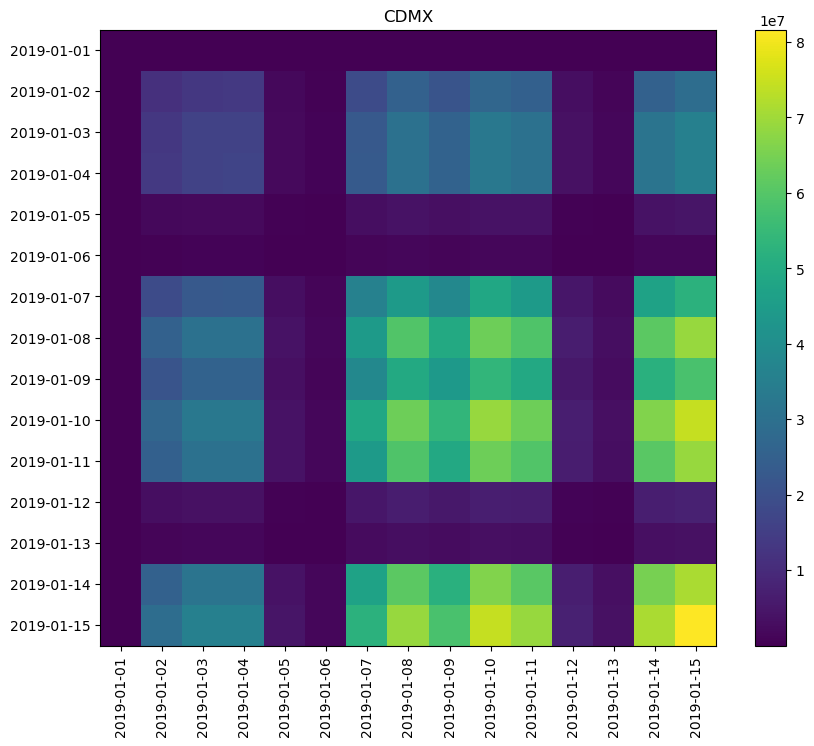

In [180]:
dates = [f"2019-01-{str(i).zfill(2)}" for i in range(1, 16)]

plot_heatmap(cdmx, "CDMX", dates)

In [181]:
cdmx_normalized = np.load("spk_matrix/cdmx_dirac_norm.npy")

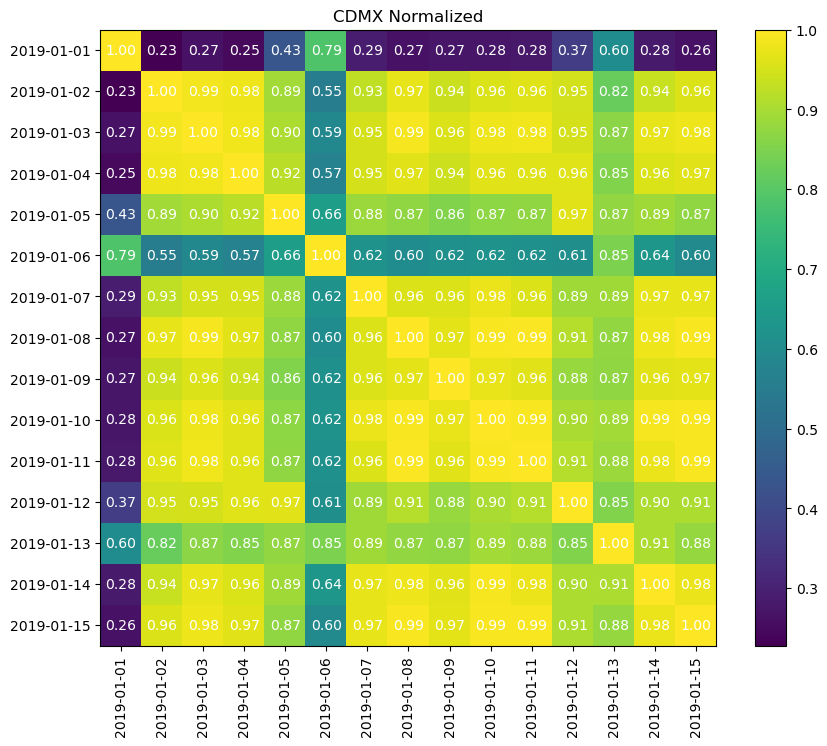

In [183]:
plot_heatmap(cdmx_normalized, "CDMX Normalized", dates, with_values=True)

In [3]:
cdmx_gaussian = np.load("spk_matrix/cdmx_gaussian.npy")

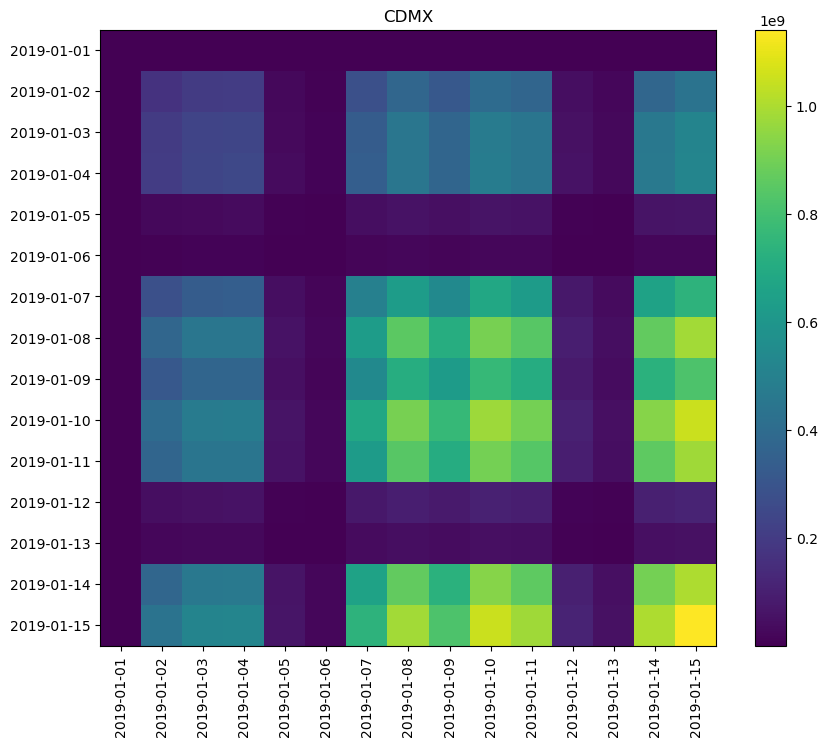

In [4]:
dates = [f"2019-01-{str(i).zfill(2)}" for i in range(1, 16)]

plot_heatmap(cdmx_gaussian, "CDMX", dates)

In [5]:
cdmx_gaussian_normalized = np.load("spk_matrix/cdmx_gaussian_norm.npy")

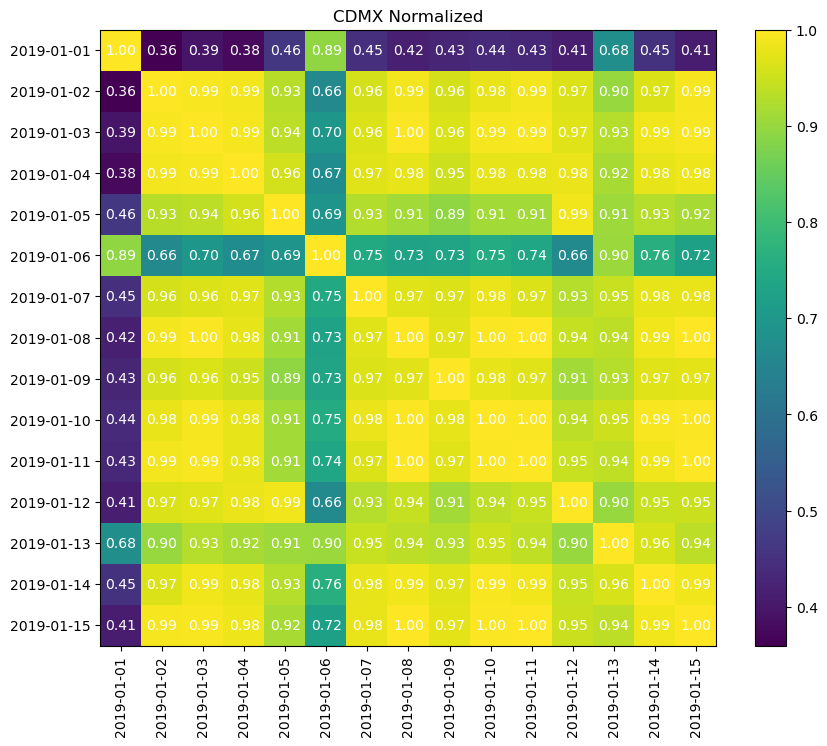

In [6]:
plot_heatmap(cdmx_gaussian_normalized, "CDMX Normalized", dates, with_values=True)